In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
import scipy
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from math import pi

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']
tilt = config['tilt'] * degrees 
#clock = config['clock']
#beam_en = config['beam_enu0']
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
#tmat = pytpc.utilities.tilt_matrix(-tilt)
# efield_uvw = tmat.dot(efield)
# bfield_uvw = tmat.dot(bfield)
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])
max_beam_angle = (config['max_beam_angle']*math.pi)/180
beam_origin_z = config['beam_origin_z']
#beampads = np.fromfile(config['beampads_path'], sep=',', dtype='int')

In [4]:
sim = EventSimulator(config)
num_evts = 100
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle, beam_origin_z, gas, num_evts)


In [5]:
p = next(pgen)
print(p)
#good_p = [[7.78580357e-03, 2.05914266e-03, 5.69142329e-01, 1.44299609e+00, 4.21022635e+00, 1.98290584e+00]]

(array([ 0.00890422, -0.0191878 ,  0.43189141,  6.15790514,  4.68219046,
        2.7652572 ]), array([ 0.01256905, -0.02708518, -0.99955411]))


In [6]:
evtRandom, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
pyevtRandom = sim.convert_event(evtRandom)
Random_xyzs = pyevtRandom.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

In [7]:
Random_xy = Random_xyzs[:, 0:2]
Random_xy_C = np.ascontiguousarray(Random_xy, dtype=np.double)
Random_cx, Random_cy = pytpc.cleaning.hough_circle(Random_xy_C)
#The center of curvature of the track, in mm.
Random_uvw, (Random_cu, Random_cv) = mcfitter.preprocess(Random_xyzs[:, 0:5], center=(Random_cx, Random_cy), rotate_pads=True)
Random_uvw_values = Random_uvw.values

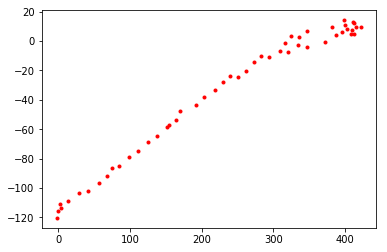

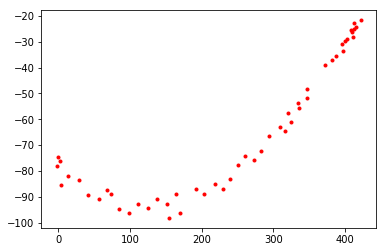

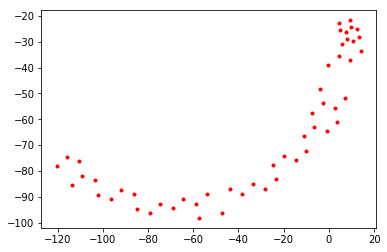

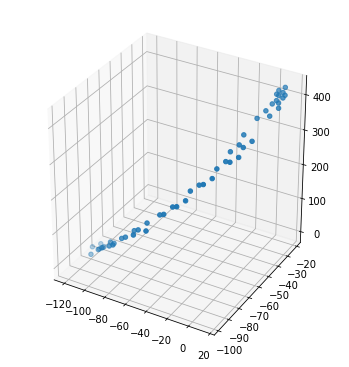

In [8]:
plt.plot(Random_uvw_values[:, 7], Random_uvw_values[:, 5], 'r.')
plt.show()
plt.plot(Random_uvw_values[:, 7], Random_uvw_values[:, 6], 'r.')
plt.show()
plt.plot(Random_uvw_values[:, 5], Random_uvw_values[:, 6], 'r.')

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(Random_uvw_values[:,5],Random_uvw_values[:,6],Random_uvw_values[:,7])

In [9]:
Random_mcres, Random_minChis, Random_all_params, Random_good_param_idx = mcfitter.process_event(Random_uvw, Random_cu, Random_cv, return_details=True)
print(Random_mcres)

{'x0': 0.009379177015138343, 'y0': 0.002563074822327156, 'z0': 0.4998119797499606, 'enu0': 8.484955247268903, 'azi0': -1.4125114516758597, 'pol0': 2.7917298411940323, 'posChi2': 3.715832906040818, 'enChi2': 12.361122749240533, 'vertChi2': 1.8907662805229353, 'lin_scat_ang': 0.4003965432257304, 'lin_beam_int': 475.4850950171687, 'lin_chi2': 23.168409097742273, 'rad_curv': 88.00777006385997, 'brho': 0.37932091510941185, 'curv_en': 6.891221279065265, 'curv_ctr_x': -77.69488527195455, 'curv_ctr_y': -13.07670169514951}


In [10]:
evtClean, ctr = sim.make_event(Random_mcres['x0'], Random_mcres['y0'], Random_mcres['z0'], Random_mcres['enu0'], Random_mcres['azi0'], Random_mcres['pol0'])
print(Random_mcres['posChi2']+Random_mcres['enChi2']+Random_mcres['vertChi2'])

pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values

17.96772193580429


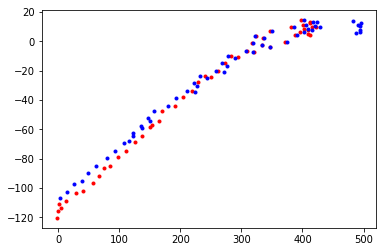

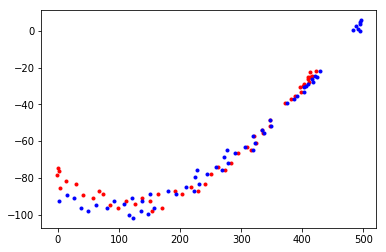

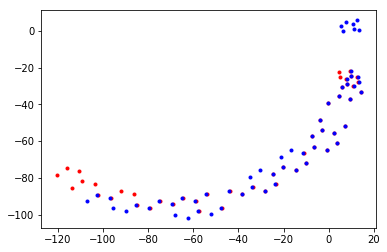

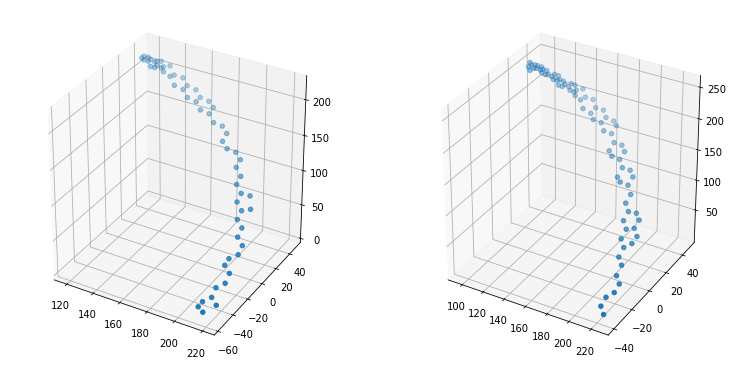

In [11]:
plt.plot(Random_uvw_values[:, 7], Random_uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.show()
plt.plot(Random_uvw_values[:, 7], Random_uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.show()
plt.plot(Random_uvw_values[:, 5], Random_uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(Random_xyzs[:,0],Random_xyzs[:,1],Random_xyzs[:,2])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_xyzs[:,0],sim_xyzs[:,1],sim_xyzs[:,2])

In [12]:
uvw_sorted = Random_uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, Random_cu, Random_cv)
ctr0 = mcfitter.guess_parameters(prefit_res)
exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000

In [13]:
exp_hits = np.zeros(10240)
for a, p in Random_uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
print(exp_hits)

[0. 0. 0. ... 0. 0. 0.]


In [14]:
minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)

In [15]:
def f(y):
    ctr = np.zeros([1,6])
    ctr[0] = y
    chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
    return sum(chi_result[0])


In [16]:
i = 1
def callbackF(x, convergence=10):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1
bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]
results = scipy.optimize.differential_evolution(f, bounds, callback=callbackF, recombination=0.7, popsize=15, mutation=(0.5, 1.0), maxiter=10000)

   1-0.003955 0.114184 0.611136 1.566711-5.789708 4.200130 394.315012
   2-0.037154 0.027755 0.772445 4.432698-2.412998 4.418783 172.005144
   3 0.001506 0.009027 0.697190 4.256586-3.243287 0.990243 134.919601
   4 0.001506 0.009027 0.697190 4.256586-3.243287 0.990243 134.919601
   5-0.004530-0.007552 0.819212 4.642336 4.572196-2.128868 131.691264
   6-0.002179-0.019787 0.962923 2.518682 2.051024-3.931348 124.709811
   7-0.002413-0.003610 0.941547 1.709106 4.451113-3.286058 122.337620
   8-0.002413-0.003610 0.941547 1.709106 4.451113-3.286058 122.337620
   9 0.022370-0.001445 0.475922 1.786225 1.451999 3.494950 110.134359
  10 0.022370-0.001445 0.475922 1.786225 1.451999 3.494950 110.134359
  11 0.022370-0.016672 0.475922 2.843366 1.510278 3.494950 99.054939
  12 0.022370-0.016672 0.475922 2.843366 1.510278 3.494950 99.054939
  13 0.022370-0.016672 0.475922 2.843366 1.510278 3.494950 99.054939
  14 0.022370-0.016672 0.475922 2.843366 1.510278 3.494950 99.054939
  15 0.022370-0.016672 0

 123 0.005291 0.001702 0.465274 4.983107 4.985134 2.730396 33.249812
 124 0.005291 0.001702 0.465274 4.983107 4.985134 2.730396 33.249812
 125 0.005291 0.001702 0.465274 4.983107 4.985134 2.730396 33.249812
 126 0.005376 0.001603 0.449612 4.995844 4.975598 2.728817 33.244859
 127 0.005854 0.003136 0.457834 4.995733 4.977946 2.725166 32.686452
 128 0.005854 0.003136 0.457834 4.995733 4.977946 2.725166 32.686452
 129 0.006280 0.001821 0.453259 4.980441 4.957957 2.721372 32.644751
 130 0.006456 0.001243 0.449752 4.994407 4.945824 2.720665 32.596748
 131 0.006456 0.001243 0.449752 4.994407 4.945824 2.720665 32.596748
 132 0.006456 0.001243 0.449752 4.994407 4.945824 2.720665 32.596748
 133 0.006456 0.001243 0.449752 4.994407 4.945824 2.720665 32.596748
 134 0.006456 0.001243 0.449752 4.994407 4.945824 2.720665 32.596748
 135 0.006456 0.001243 0.449752 4.994407 4.945824 2.720665 32.596748
 136 0.006456 0.001243 0.449752 4.994407 4.945824 2.720665 32.596748
 137 0.007829 0.001582 0.447232 4.

In [17]:
results.fun

31.90489753377249

In [18]:
dfe = results.x
print(dfe)

[6.32237189e-03 2.65713295e-04 4.48695035e-01 4.99256933e+00
 4.94208024e+00 2.72270856e+00]


In [19]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(dfe[0], dfe[1], dfe[2], dfe[3], dfe[4], dfe[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

In [20]:
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values

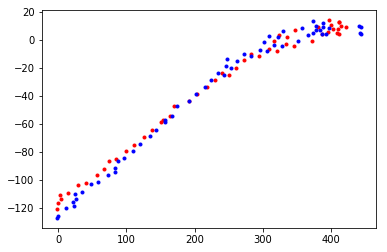

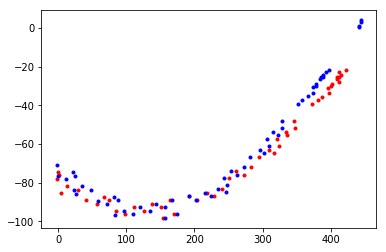

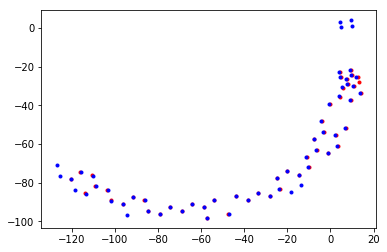

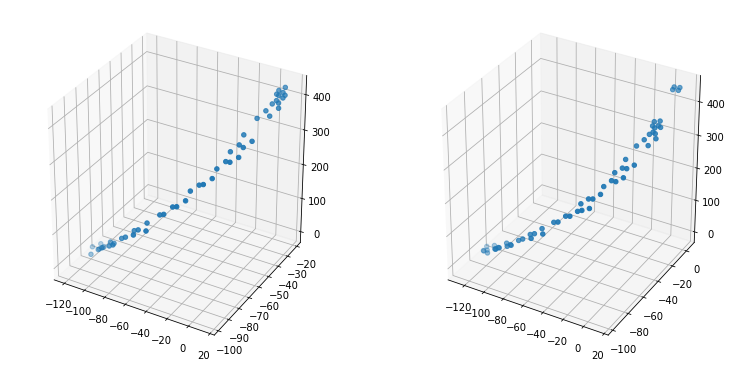

In [21]:
plt.plot(Random_uvw_values[:, 7], Random_uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.show()
plt.plot(Random_uvw_values[:, 7], Random_uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.show()
plt.plot(Random_uvw_values[:, 5], Random_uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(Random_uvw_values[:,5],Random_uvw_values[:,6],Random_uvw_values[:,7])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,5],sim_uvw_values[:,6],sim_uvw_values[:,7])

In [22]:
i = 1
def callbackF(x, f, accept):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f))
    i += 1

In [23]:
bh_nm_results = scipy.optimize.basinhopping(f,ctr0, callback=callbackF, niter=25, T=0.01, stepsize=0.05, minimizer_kwargs={"method": "SLSQP"})
#SLSQP did not work for simulated data somehow..
print(bh_nm_results)

   1 0.007354 0.000720 0.472503 5.821586-1.357512 2.751336 26.111754
   2 0.002410 0.000660 0.484055 5.683642-1.265086 2.773863 33.367064
   3 0.004536-0.004398 0.464159 6.365578-1.372746 2.774010 33.844560
   4 0.002571-0.001123 0.470036 5.395963-1.288300 2.761389 34.684203
   5 0.004110 0.002859 0.482588 5.474192-1.256280 2.762002 32.464617
   6 0.002709-0.001996 0.473862 5.436377-1.282059 2.774098 36.363032
   7 0.001761 0.002225 0.488574 5.743069-1.241562 2.778531 33.838437
   8 0.001134 0.000419 0.477538 5.032424-1.210303 2.763765 38.413598
   9 0.005063 0.001588 0.507564 6.065362-1.271871 2.798290 37.516432
  10 0.003057 0.000376 0.478287 5.469871-1.265465 2.766893 33.570629
  11 0.005281-0.004512 0.478109 5.810305-1.399845 2.793288 44.099524
  12 0.028461 0.001760 0.487161 6.903251-1.516261 2.740639 54.530541
  13 0.002339 0.000810 0.478755 5.387116-1.254994 2.763539 34.890799
  14 0.001944 0.000150 0.477007 5.274024-1.246723 2.765630 35.864718
  15 0.009467 0.001229 0.481927 5.

In [24]:
bh_nm = bh_nm_results.x
print(bh_nm)

[ 7.35412688e-03  7.20313019e-04  4.72503404e-01  5.82158570e+00
 -1.35751182e+00  2.75133554e+00]


In [25]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(bh_nm[0], bh_nm[1], bh_nm[2], bh_nm[3], bh_nm[4], bh_nm[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values

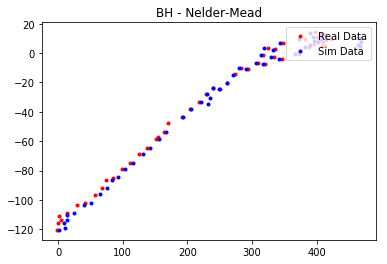

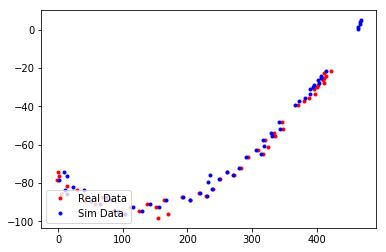

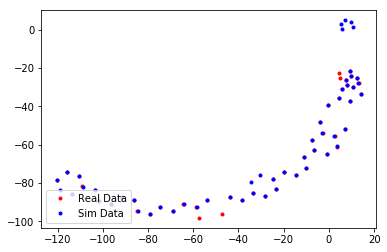

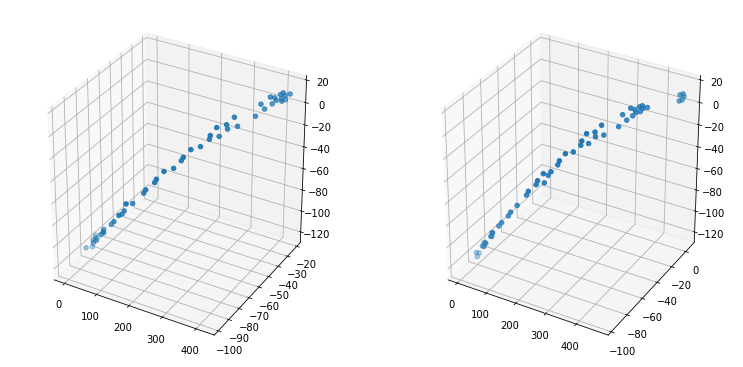

In [26]:
%matplotlib inline

plt.plot(Random_uvw_values[:, 7], Random_uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Data')
plt.legend(loc=1)
plt.title("BH - Nelder-Mead")
plt.show()

plt.plot(Random_uvw_values[:, 7], Random_uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Data')
plt.legend(loc=3)
plt.show()

plt.plot(Random_uvw_values[:, 5], Random_uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Data')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(Random_uvw_values[:,7],Random_uvw_values[:,6],Random_uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])
